In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43331")
client

<Client: 'tcp://127.0.0.1:43331' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

# Wavelet
## Native grid

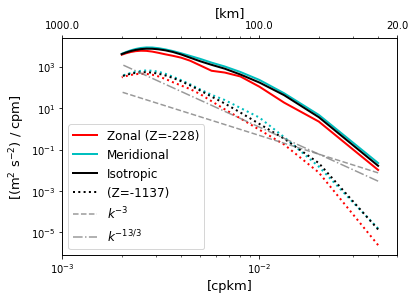

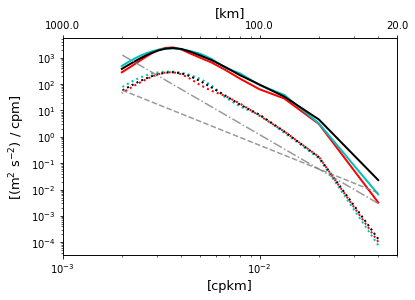

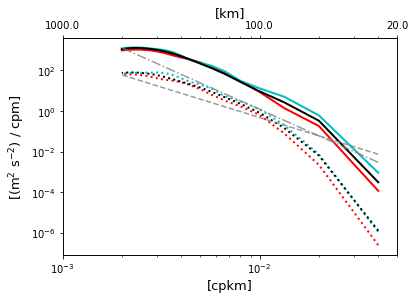

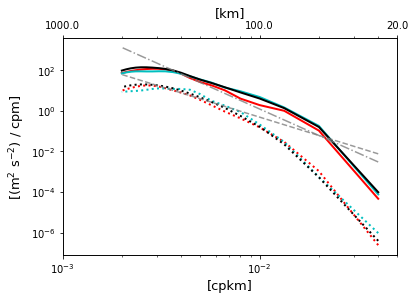

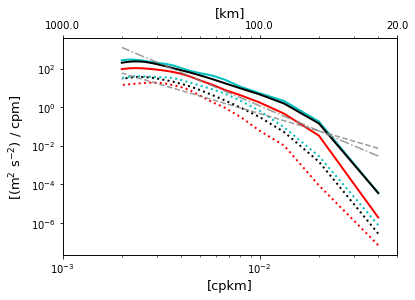

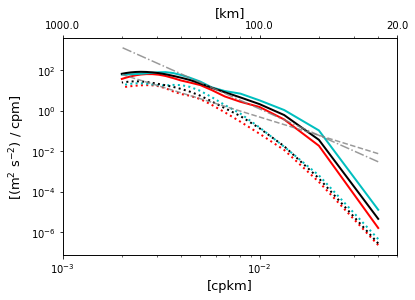

In [7]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])

            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1})
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1})

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,'Z':up.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
        
            
            ntheta = 36
            iso_psU = xwavelet.wvlt_power_spectrum(
                    up, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
            iso_psV = xwavelet.wvlt_power_spectrum(
                    vp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

            fig, ax = plt.subplots()
            ax2 = ax.twiny()
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=0).mean(['nmemb']),
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb']),
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=0).mean(['nmemb','angle']),
                    'k', lw=2, label=r"Isotropic")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=1).mean(['nmemb']),
                    'r:', lw=2)
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb']),
                    'c:', lw=2)
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=1).mean(['nmemb','angle']),
                    'k:', lw=2, label=r"(Z=-1137)")
            ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                     ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
            ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
                     ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
            ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                     ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax2.set_xscale('log')
            ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax2.set_xlim([1e-3,5e-2])
            ax2.set_xticks([1e-3,1e-2,5e-2])
            ax2.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax2.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
            if reg == 0:
                ax.legend(loc='lower left', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/KE-spec_Region%02d.pdf' % reg))
        plt.show()

## Uniform grid

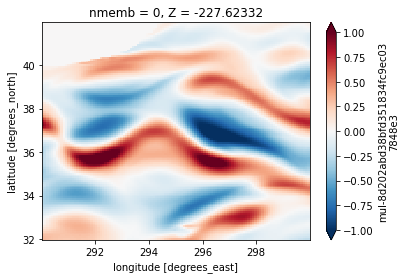

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


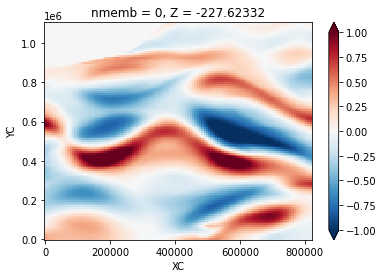

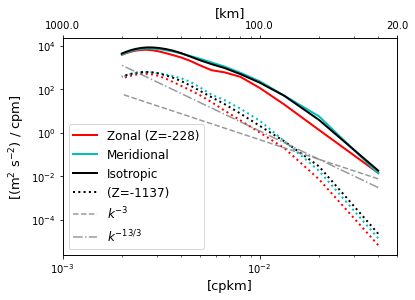

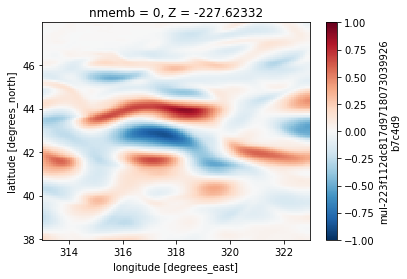

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


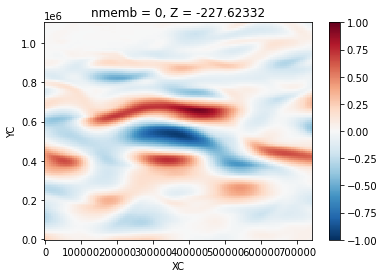

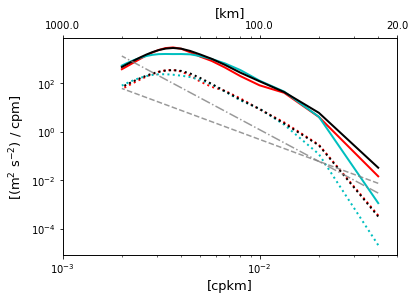

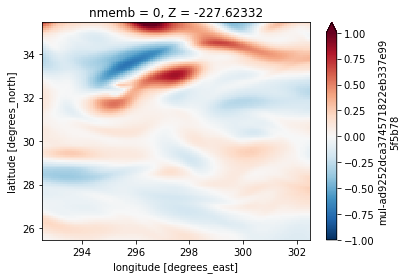

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


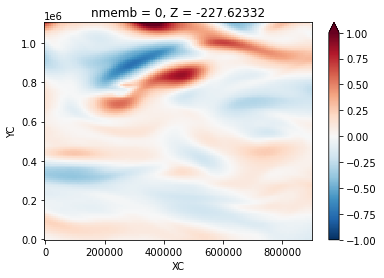

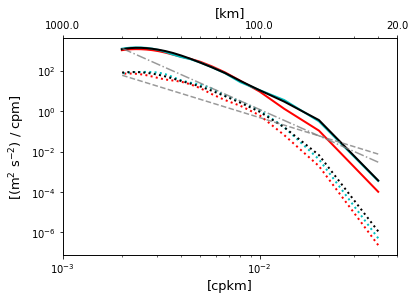

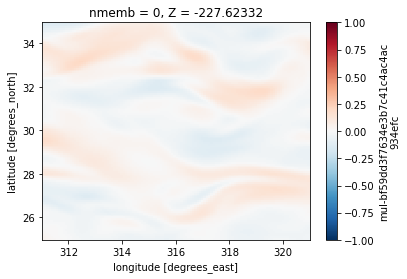

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


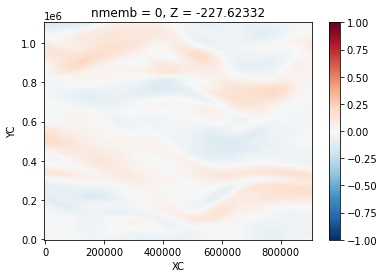

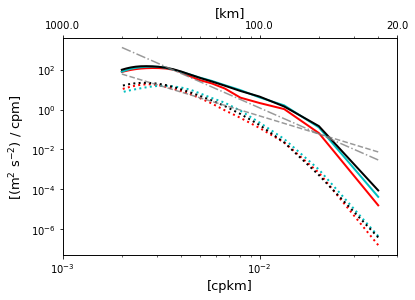

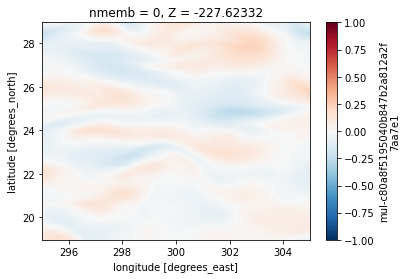

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


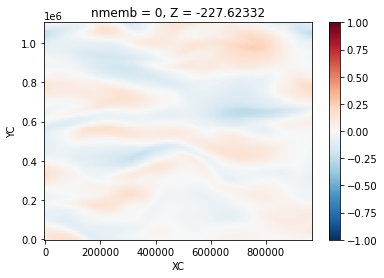

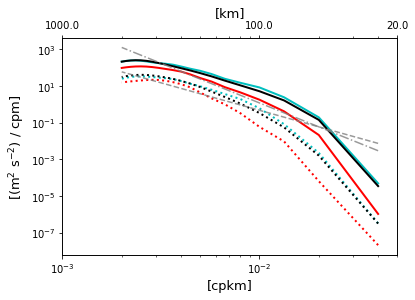

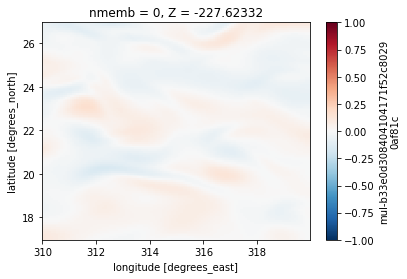

<xarray.DataArray 'dxC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days <xarray.DataArray 'dyC' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 1421280
    time     timedelta64[ns] 3290 days


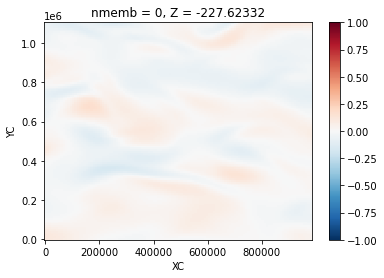

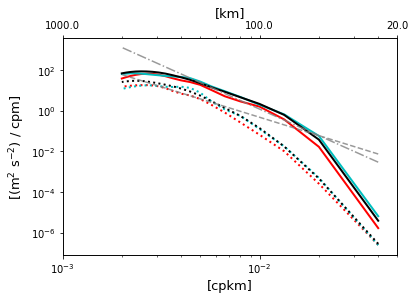

In [8]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])

            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend'
                            ).isel(Z=[14,24]).load().interpolate_na(dim='XC'
                                                                   ).interpolate_na(dim='YC'
                                                                                   ).fillna(0.)
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend'
                            ).isel(Z=[14,24]).load().interpolate_na(dim='YC'
                                                                   ).interpolate_na(dim='XC'
                                                                                   ).fillna(0.)
            up.isel(nmemb=0,Z=0).plot(vmax=1, vmin=-1, cmap='RdBu_r')
            plt.show()

            xT = grid.cumsum(ds.dxC,'X',boundary='extend')
            yT = grid.cumsum(ds.dyC,'Y',boundary='extend')
            xT = (xT - xT.isel(XC=0)).values.flatten()
            yT = (yT - yT.isel(YC=0)).values.flatten()
            print(ds.dxC.mean(), ds.dyC.mean())
            dx = ds.dxC.min().values
            dy = ds.dyC.min().values
            N = up.isel(nmemb=0,Z=0).shape

            uterp = xr.DataArray(np.ones_like(up), dims=up.dims,
                                 coords={'nmemb':nmembs,'Z':up.Z,
                                         'YC':np.arange(0,N[-2]*dy,dy),
                                         'XC':np.arange(0,N[-1]*dx,dx)}
                                )
            vterp = xr.DataArray(np.ones_like(vp), dims=vp.dims,
                                 coords={'nmemb':nmembs,'Z':vp.Z,
                                         'YC':np.arange(0,N[-2]*dy,dy),
                                         'XC':np.arange(0,N[-1]*dx,dx)}
                                )
            mask = xr.DataArray(~ds.maskC.isel(Z=[14,24]).load(), 
                                dims=vp.isel(nmemb=0).dims,
                                coords={'Z':vp.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
    #         xx, yy = np.meshgrid(np.arange(0,N[-1]*dx,dx), np.arange(0,N[-2]*dx,dx))
            xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
            for nn in range(len(nmembs)):
                for iz in range(len(up.Z)):
    #                 f = interp2d(dxT, dyT,
    #                              up.isel(nmemb=nn,Z=iz).data, 
    #                             )
                    uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                            (up*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                            (xxx, yyy) 
                                                           ).T / (dx*dy)
    #                 tck = bisplrep(dxT, dyT, 
    #                                up.isel(nmemb=nn,Z=iz).values.flatten(), 
    # #                                s=np.prod(N[-2:])
    # #                                s=np.prod(N[-2:])-np.sqrt(2*np.prod(N[-2:]))
    #                                s=0.
    #                               )
    #                 uterp.isel(nmemb=nn,Z=iz)[:] = np.ma.masked_array(bisplev(xx[:,0], yy[0,:], tck),
    #                                                                   mask.isel(Z=iz).data
    #                                                                  )
    #                 del tck
    #                 f = interp2d(dxT, dyT,
    #                              vp.isel(nmemb=nn,Z=iz).data, 
    #                             )
                    vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                            (vp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                            (xxx, yyy) 
                                                           ).T / (dx*dy)
    #                 tck = bisplrep(dxT, dyT, vp.isel(nmemb=nn,Z=iz).data, 
    # #                                s=np.prod(N[-2:])
    # #                                s=np.prod(N[-2:])-np.sqrt(2*np.prod(N[-2:]))
    #                                s=0.
    #                               )
    #                 vterp.isel(nmemb=nn,Z=iz)[:] = np.ma.masked_array(bisplev(xx[:,0], yy[0,:], tck),
    #                                                                   mask.isel(Z=iz).data
    #                                                                  )
    #                 del tck
                    if nn == 0 and iz == 0:
                        uterp.isel(nmemb=nn,Z=iz).plot(vmax=1, vmin=-1, cmap='RdBu_r')
                        plt.show()
    #             print(nn)


            iso_psU = xwavelet.wvlt_power_spectrum(
                    uterp.chunk({'nmemb':1}), s, dim=["YC", "XC"], xo=xo
            )
            iso_psV = xwavelet.wvlt_power_spectrum(
                    vterp.chunk({'nmemb':1}), s, dim=["YC", "XC"], xo=xo
            )

            fig, ax = plt.subplots()
            ax2 = ax.twiny()
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=0).mean(['nmemb']),
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=3,Z=0).mean(['nmemb']),
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=0).mean(['nmemb','angle']),
                    'k', lw=2, label=r"Isotropic")
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=0,Z=1).mean(['nmemb']),
                    'r:', lw=2)
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(angle=3,Z=1).mean(['nmemb']),
                    'c:', lw=2)
            ax.plot((iso_psU.scale)**-1*1e3, .5*(iso_psU + iso_psV).isel(Z=1).mean(['nmemb','angle']),
                    'k:', lw=2, label=r"(Z=-1137)")
            ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                     ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
            ax.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-(13/3)*6e-2, 
                     ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
            ax2.plot((iso_psU.scale)**-1*1e3, ((iso_psU.scale/xo)**-1)**-3*6e-2, 
                     ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax2.set_xscale('log')
            ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax2.set_xlim([1e-3,5e-2])
            ax2.set_xticks([1e-3,1e-2,5e-2])
            ax2.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax2.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
            if reg == 0:
                ax.legend(loc='lower left', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/interpKE-spec_Region%02d.pdf' % reg))
            plt.show()

# Fourier

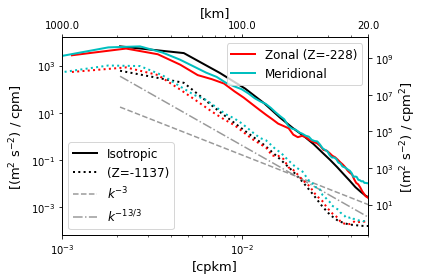

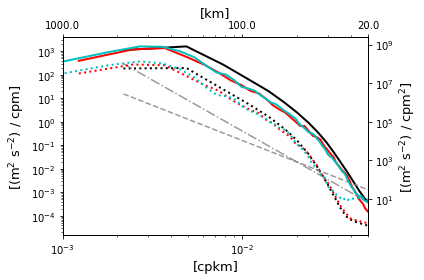

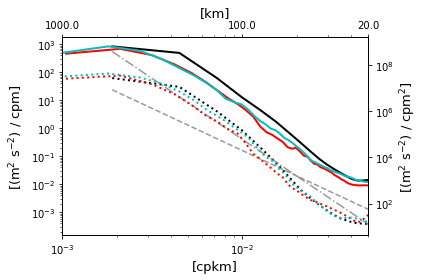

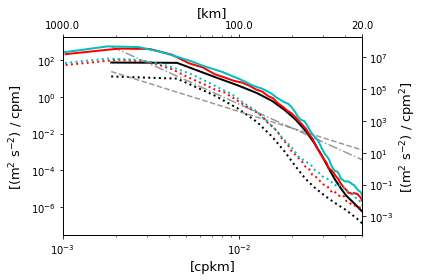

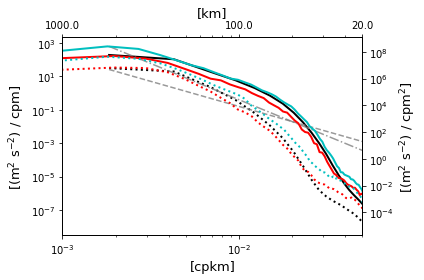

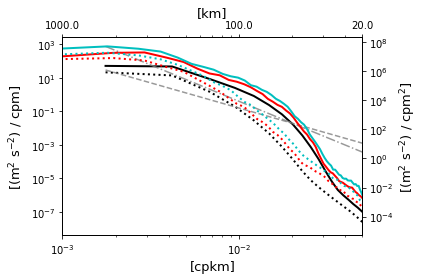

In [12]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])

            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                   ).interpolate_na(dim='YC'
                                                                                   ).fillna(0.)
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend').isel(Z=[14,24]).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='YC'
                                                                   ).interpolate_na(dim='XC'
                                                                                   ).fillna(0.)

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,'Z':up.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,'Z':vp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )

            psU = xrft.power_spectrum(
                    up, dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True
            )
            psV = xrft.power_spectrum(
                    vp, dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True
            )

            iso_psU = xrft.isotropic_power_spectrum(
                    up, dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
            )
            iso_psV = xrft.isotropic_power_spectrum(
                    vp, dim=["YC", "XC"], window='hann', 
                    window_correction=True, true_amplitude=True, truncate=True
            )

            fig, ax = plt.subplots()
            fig.set_tight_layout(True)
            ax2 = ax.twinx()
            ax3 = ax.twiny()
            ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                    .5*(psU + psV).isel(Z=0,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                    .5*(psU + psV).isel(Z=0,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                    'c', lw=2, label=r"Meridional")
            ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=0,freq_r=slice(None,None)).mean(['nmemb']),
                    'k', lw=2, label=r"Isotropic")
            ax2.plot(psU.freq_XC[int(N[-1]/2)+1:]*1e3, 
                    .5*(psU + psV).isel(Z=1,freq_XC=slice(int(N[-1]/2)+1,None)).sel(freq_YC=0).mean(['nmemb']),
                    'r:', lw=2)
            ax2.plot(psU.freq_YC[int(N[-2]/2)+1:]*1e3, 
                    .5*(psU + psV).isel(Z=1,freq_YC=slice(int(N[-2]/2)+1,None)).sel(freq_XC=0).mean(['nmemb']),
                    'c:', lw=2)
            ax.plot(iso_psU.freq_r[:]*1e3, .5*(iso_psU + iso_psV).isel(Z=1,freq_r=slice(None,None)).mean(['nmemb']),
                    'k:', lw=2, label=r"(Z=-1137)")
            ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-3*2e-2, 
                     ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
            ax.plot(iso_psU.freq_r*1e3, (iso_psU.freq_r*xo)**-(13/3)*2e-2, 
                     ls='-.', c='grey', alpha=.8, label=r"$k^{-13/3}$")
            ax3.plot(iso_psU.freq_r*1e3, xr.ones_like(iso_psU.freq_r)*1e1, 
                     ls='--', c='grey', alpha=0)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax2.set_xscale('log')
            ax2.set_yscale('log')
            ax3.set_xscale('log')
            ax3.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
            ax2.set_ylabel(r"[(m$^2$ s$^{-2}$) / cpm$^2$]", fontsize=13)
            if reg == 0:
                ax.legend(loc='lower left', fontsize=12)
                ax2.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/KE-Fourierspec_Region%02d.pdf' % reg))
            plt.show()